In [1]:
import torch
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from  torchvision import models
import torch.nn as nn
from torch import optim
from sklearn.metrics import roc_curve,auc,roc_auc_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score

#****************setting*******************
NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS= 10
input_dim = 128
num_classes = 2 # Classification number

TRAIN_DATASET_DIR = r'E:\Code\Classify\data\gender_rev2\train'
VALID_DATASET_DIR = r'E:\Code\Classify\data\gender_rev2\valid'
TEST_DATASET_DIR = r'E:\Code\Classify\data\gender_rev2\test'
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
show_interval_num = 10

# Custom loss function

In [2]:
#Custom loss function
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        self.name = 'myloss'
    def forward(self, input, target):
        loss = -torch.mean(torch.sum(F.one_hot(target,2) * torch.log(input), axis = 1))
        return loss

# Define training and validation procedures

In [3]:
#Define training and validation procedures
def train(model, device, train_loader, optimizer, epoch,loss_func):
    model.train()
    train_loss = 0.
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % show_interval_num == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,accuracy
def valid(model, device, test_loader,loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss,accuracy
def test(model, device, test_loader,loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_scores.append(output.detach().cpu().numpy())
            y_true.append(target.cpu().numpy())
            # sum up batch loss
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss,accuracy,y_scores,y_true

# Data partitioning and data preprocessing

In [4]:
#********Set the data enhancement mode**********
#For train_data
train_transforms = transforms.Compose(
        [transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),#Random rotation
        transforms.RandomHorizontalFlip(),#Random horizontal flip
        transforms.CenterCrop(size=112),#Center crop to 112*112
        transforms.ToTensor(),#Convert to a tensor,# normalize
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])#standardization
])
#For the test set,test data, the test does not need random center clipping, directly resize to 112*112
test_valid_transforms = transforms.Compose(
        [transforms.Resize((112,112)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406],
         [0.229, 0.224, 0.225])])

In [5]:
#dataset split
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
train_data_size = len(train_datasets)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR,transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=TEST_BATCH_SIZE, shuffle=True)
valid_data_size = len(valid_datasets)

# Resnet34

In [6]:
model = models.resnet34(pretrained=True)
# Freezing parameters
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.requires_grad = True

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

Train Epoch: 1 [0/3491 (0%)]	Loss: 0.812949
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.615383
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.518385

Test set: Average loss: 0.0057, Accuracy: 145/200 (72%)

valid accuracy %g 72.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.545653
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.437196
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.445436

Test set: Average loss: 0.0046, Accuracy: 161/200 (80%)

valid accuracy %g 80.5
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.413389
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.444128
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.488523

Test set: Average loss: 0.0043, Accuracy: 165/200 (82%)

valid accuracy %g 82.5
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.382147
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.404351
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.355449

Test set: Average loss: 0.0044, Accuracy: 166/200 (83%)

valid accuracy %g 83.0
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.403077
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.349573
Train Epoch: 5 [2560/349

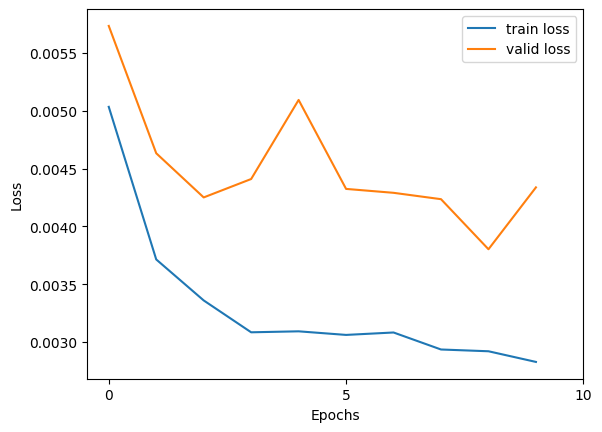

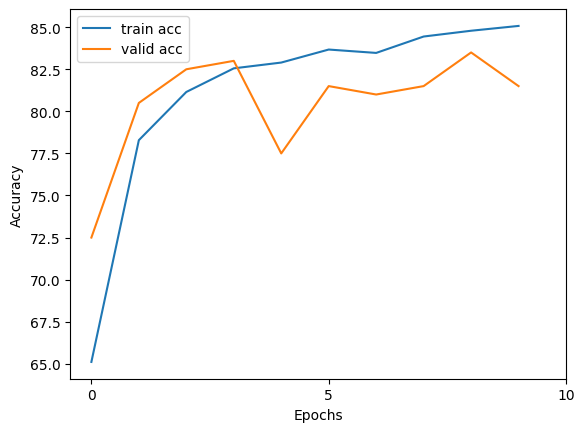

In [8]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.004 , final accuracy is 81.50
Accuracy: 0.59
Precision: 1.00
Recall: 0.19
F1 Score: 0.32
Sensitivity: 0.19
Specificity: 0.41


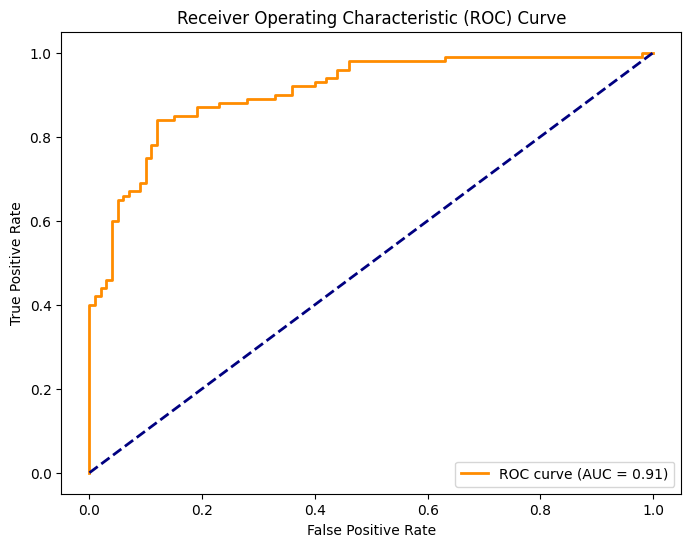

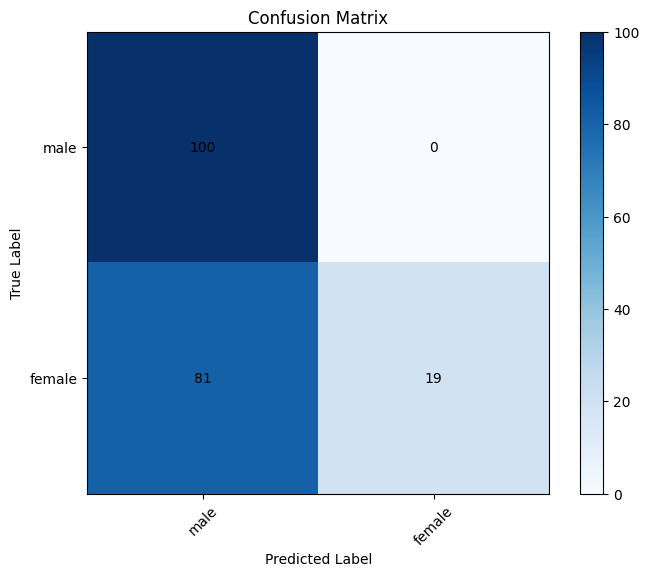

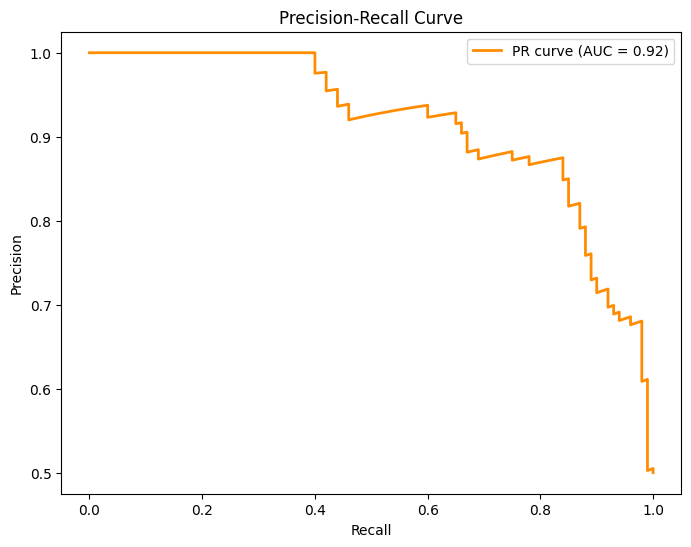

In [9]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

## Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# ResNet18

In [10]:
model = models.resnet18(pretrained=True)
# Freezing parameters
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.requires_grad = True

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#*************************Load data * via the dataload that comes with pytorch**************************
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

Train Epoch: 1 [0/3491 (0%)]	Loss: 0.902163
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.580660
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.536808

Test set: Average loss: 0.0069, Accuracy: 134/200 (67%)

valid accuracy %g 67.0
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.476715
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.546073
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.439618

Test set: Average loss: 0.0052, Accuracy: 152/200 (76%)

valid accuracy %g 76.0
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.430698
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.382957
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.497708

Test set: Average loss: 0.0045, Accuracy: 160/200 (80%)

valid accuracy %g 80.0
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.477507
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.390938
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.388277

Test set: Average loss: 0.0046, Accuracy: 160/200 (80%)

valid accuracy %g 80.0
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.408934
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.394861
Train Epoch: 5 [2560/349

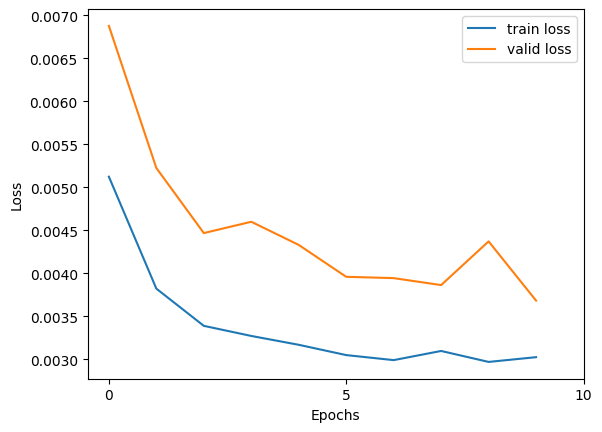

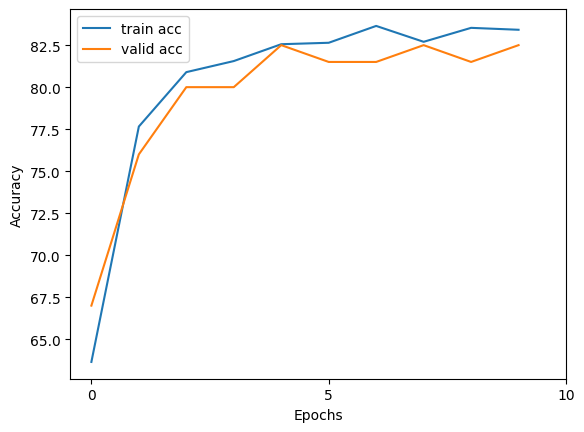

In [12]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.004 , final accuracy is 82.50
Accuracy: 0.79
Precision: 0.87
Recall: 0.67
F1 Score: 0.76
Sensitivity: 0.67
Specificity: 0.21


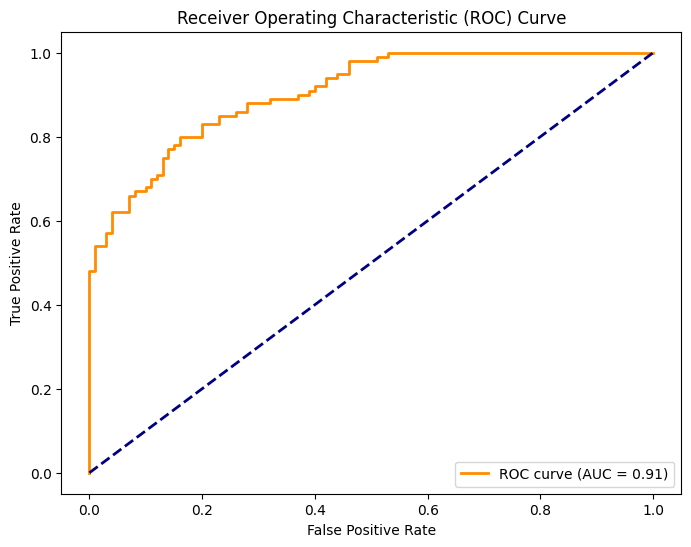

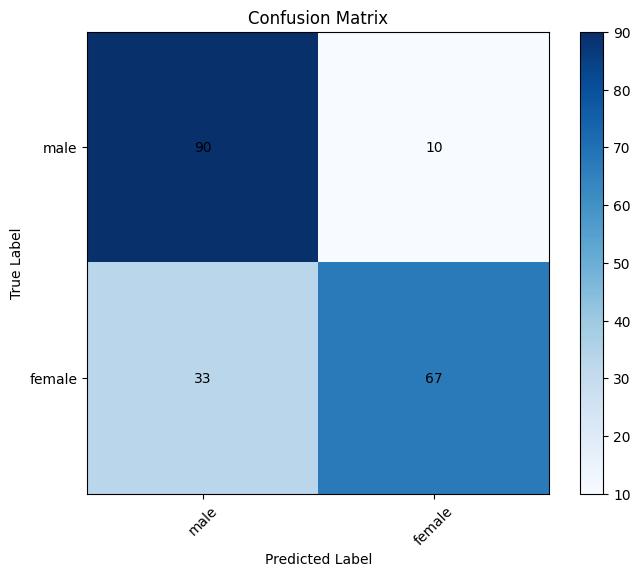

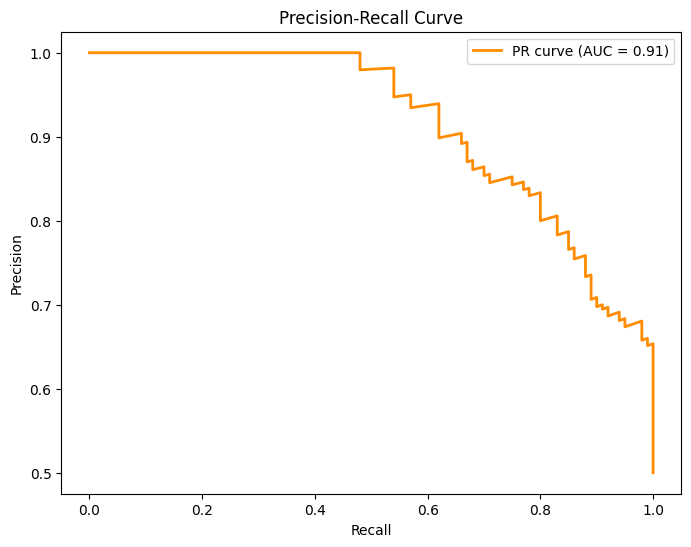

In [13]:
#Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# MobileNetV2

In [14]:
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer and set the parameters of this layer to trainable
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[1].requires_grad = True

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#*************************Load data * via the dataload that comes with pytorch**************************
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

Train Epoch: 1 [0/3491 (0%)]	Loss: 0.811365
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.583156
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.527497

Test set: Average loss: 0.0044, Accuracy: 163/200 (82%)

valid accuracy %g 81.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.451216
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.499801
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.500346

Test set: Average loss: 0.0043, Accuracy: 166/200 (83%)

valid accuracy %g 83.0
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.527578
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.337100
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.457957

Test set: Average loss: 0.0039, Accuracy: 171/200 (86%)

valid accuracy %g 85.5
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.434390
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.418704
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.341731

Test set: Average loss: 0.0042, Accuracy: 163/200 (82%)

valid accuracy %g 81.5
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.389433
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.444791
Train Epoch: 5 [2560/349

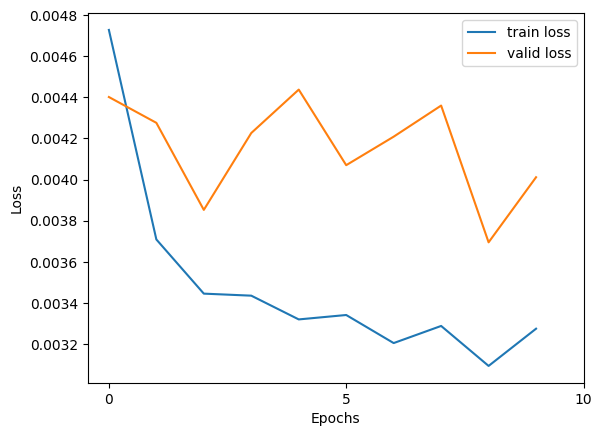

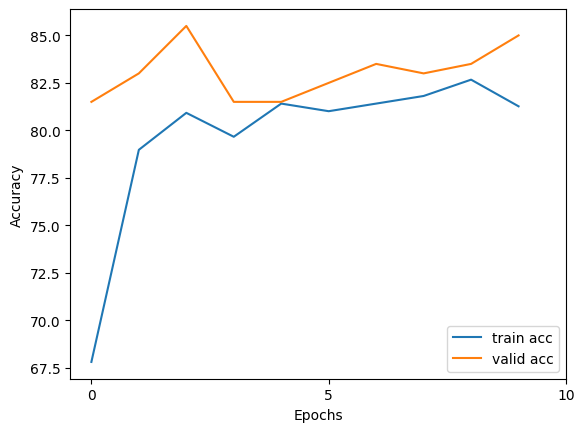

In [16]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.004 , final accuracy is 85.00
Accuracy: 0.75
Precision: 0.95
Recall: 0.53
F1 Score: 0.68
Sensitivity: 0.53
Specificity: 0.25


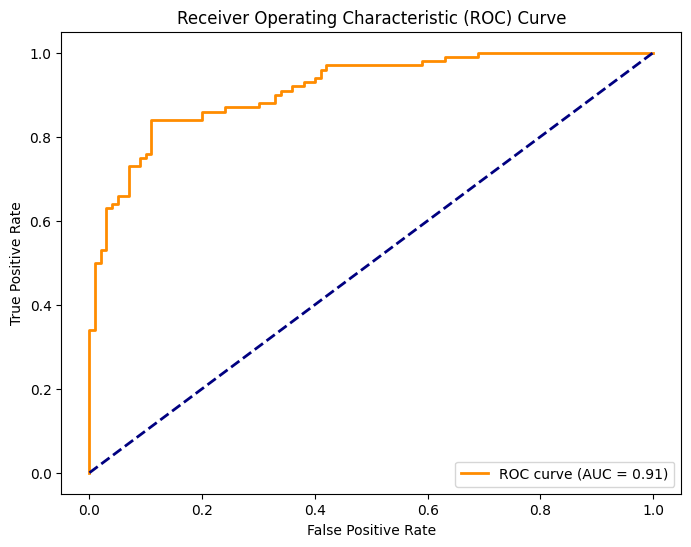

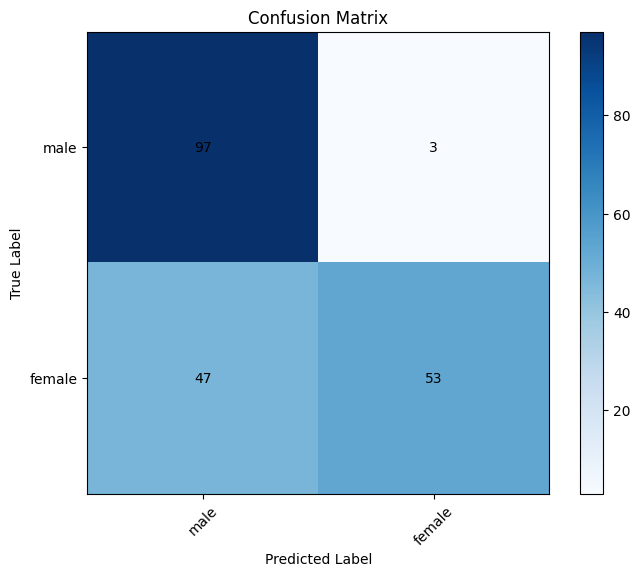

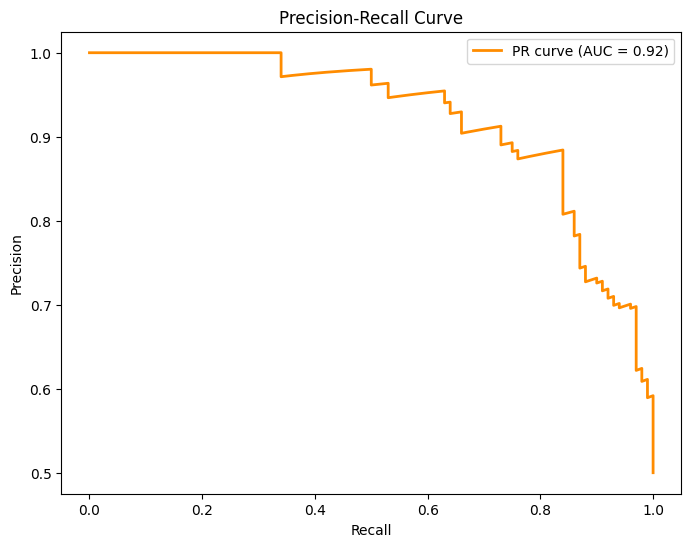

In [17]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# Net1

In [18]:
#Net1
class Raw_Net1(nn.Module):
    def __init__(self,input_dim,num_classes):
        super(Raw_Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 3 * 3, input_dim)
        self.fc2 = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(self.fc2(x))
        return x

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#*************************Load data * via the dataload that comes with pytorch**************************
# ImageFolder assumes that all files are stored in folders, each folder stores the same type of graph, 
#focusing on the __getitem__ function, which returns each graph and label according to the index
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = Raw_Net1(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1800\1895039559.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.698445
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.626578
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.593506

Test set: Average loss: 0.0046, Accuracy: 161/200 (80%)

valid accuracy %g 80.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.491404
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.537386
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.507734

Test set: Average loss: 0.0039, Accuracy: 160/200 (80%)

valid accuracy %g 80.0
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.543046
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.447906
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.360429

Test set: Average loss: 0.0028, Accuracy: 180/200 (90%)

valid accuracy %g 90.0
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.338771
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.300351
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.300352

Test set: Average loss: 0.0027, Accuracy: 177/200 (88%)

valid accuracy %g 88.5
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.292939
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.282720
Train Epoch: 5 [2560/349

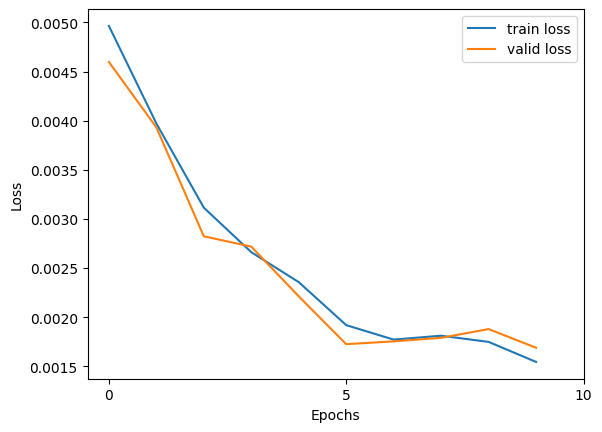

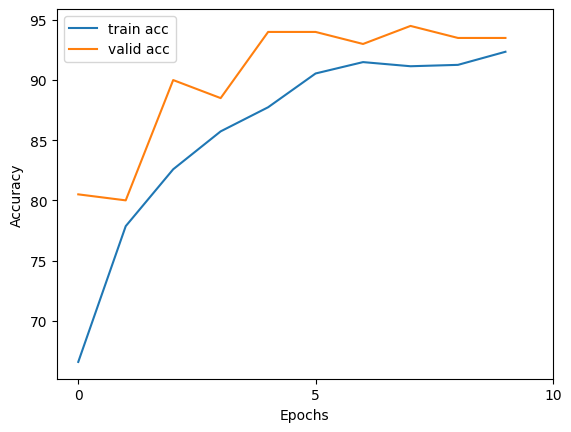

In [20]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1800\1895039559.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Final loss is 0.002 , final accuracy is 93.50
Accuracy: 0.94
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Sensitivity: 0.93
Specificity: 0.07


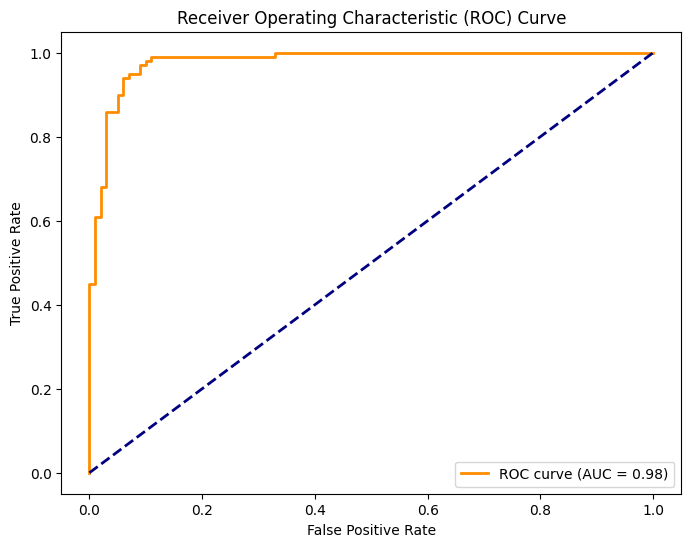

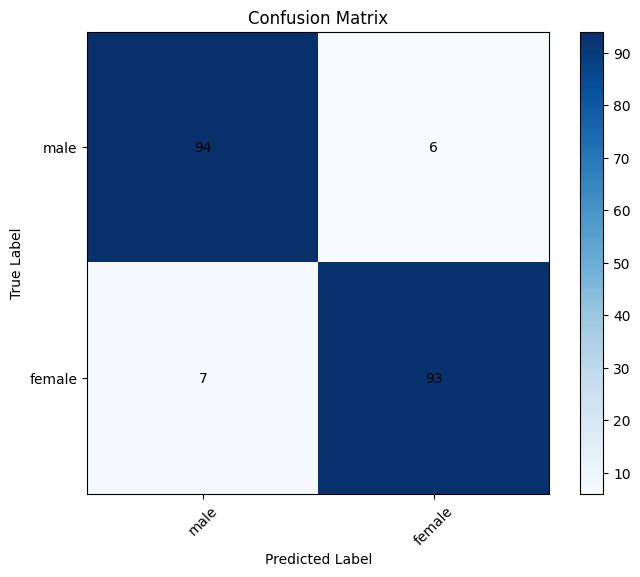

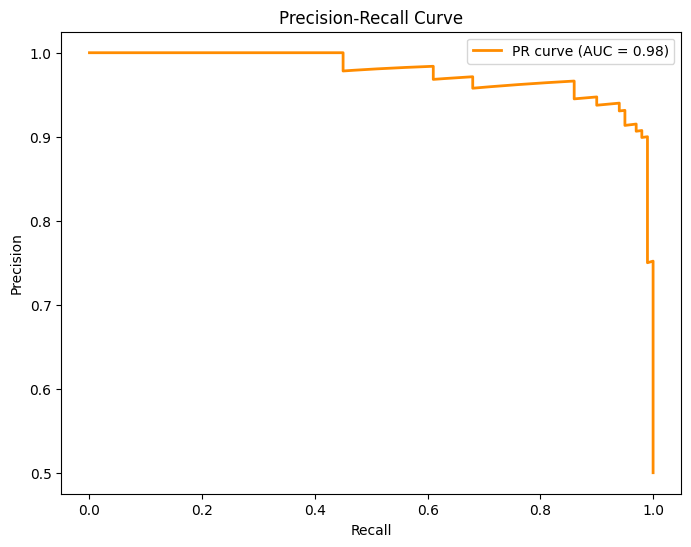

In [21]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# Net2

In [22]:
#net2
class Raw_Net2(nn.Module):
    def __init__(self,input_dim,num_classes):
        super(Raw_Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, input_dim)
        self.fc2 = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.softmax(self.fc2(x))
        return x

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#*************************Load data * via the dataload that comes with pytorch**************************
# ImageFolder assumes that all files are stored in folders, each folder stores the same type of graph, 
#focusing on the __getitem__ function, which returns each graph and label according to the index
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = Raw_Net2(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1800\3351339562.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.690657
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.667863
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.617492

Test set: Average loss: 0.0055, Accuracy: 153/200 (76%)

valid accuracy %g 76.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.609971
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.578690
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.469481

Test set: Average loss: 0.0048, Accuracy: 154/200 (77%)

valid accuracy %g 77.0
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.536430
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.479378
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.491694

Test set: Average loss: 0.0037, Accuracy: 166/200 (83%)

valid accuracy %g 83.0
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.388836
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.352765
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.345012

Test set: Average loss: 0.0039, Accuracy: 159/200 (80%)

valid accuracy %g 79.5
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.509109
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.367399
Train Epoch: 5 [2560/349

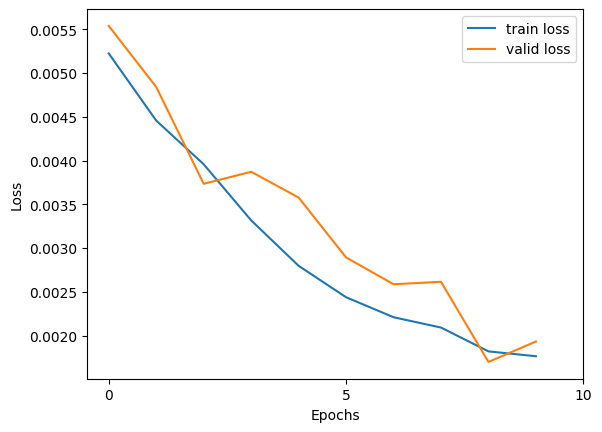

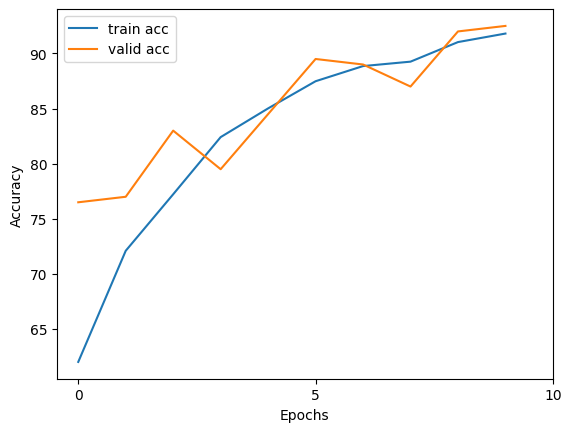

In [24]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.002 , final accuracy is 92.50
Accuracy: 0.93
Precision: 0.97
Recall: 0.88
F1 Score: 0.92
Sensitivity: 0.88
Specificity: 0.07


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1800\3351339562.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


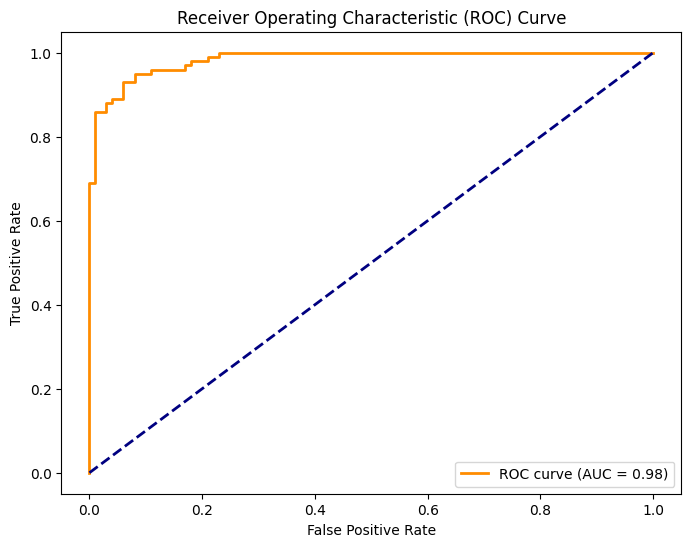

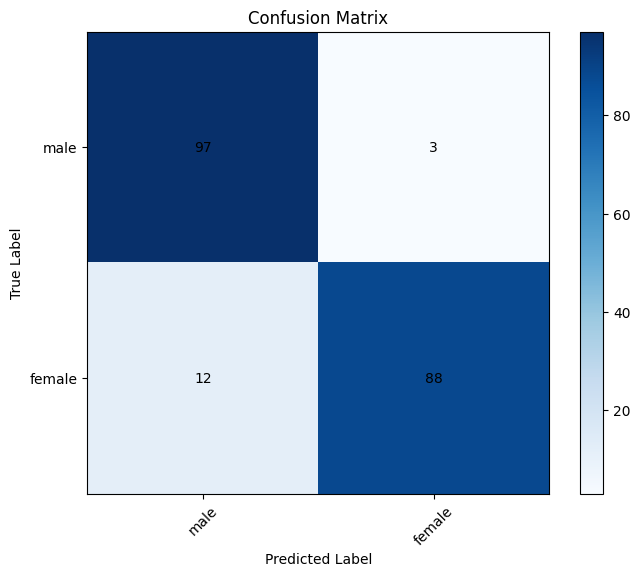

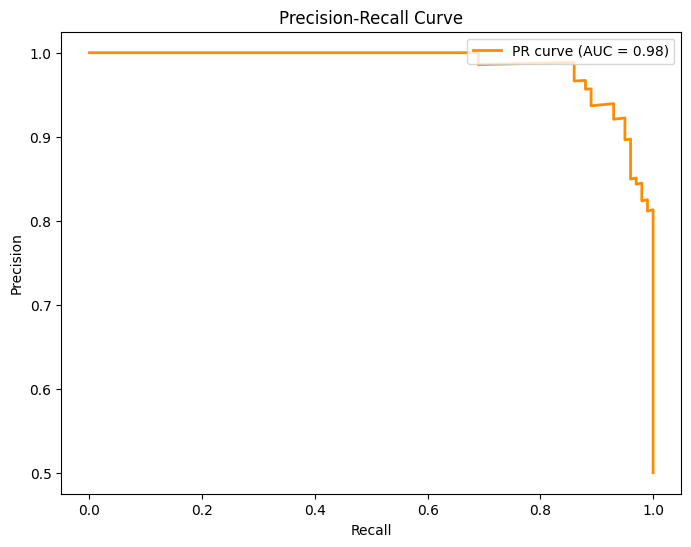

In [25]:
#Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# Combined model

In [26]:
#Net1
class Net1(nn.Module):
    def __init__(self,input_dim):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 3 * 3, input_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x
#Net2
class Net2(nn.Module):
    def __init__(self,input_dim):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, input_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x    
    
# Attention mechanism
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(input_dim, input_dim, bias=False)
        self.V = nn.Linear(input_dim, 1, bias=False)

    def forward(self, x):
        attention_weights = torch.tanh(self.W(x))
        attention_scores = torch.softmax(self.V(attention_weights), dim=1)
        context_vector = attention_scores * x
        attended_vector = torch.sum(context_vector, dim=1)
        return attended_vector

# Ensemble  Model
class EnsembleModel(nn.Module):
    def __init__(self,input_dim,num_classes):
        super(EnsembleModel, self).__init__()
        self.cnn1 = Net1(input_dim)
        self.cnn2 = Net2(input_dim)
        self.attention = Attention(2*input_dim)
        self.classifier = nn.Sequential(
            nn.Linear(2*input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, num_classes),
            nn.Softmax()
        )
    def forward(self, x):
        # The input is passed to both CNNS separately
        out1 = self.cnn1(x)
        out2 = self.cnn2(x)

         # Splice the output of the two models together
        concatenated_output = torch.cat([out1, out2], dim=1)

        # The spliced output is processed through attention mechanisms
        attended_output = self.attention(concatenated_output)

        # Final classification
        output = self.classifier(concatenated_output)
        return output

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#*******************Load data * via the dataload that comes with pytorch**********
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = EnsembleModel(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

D:\Anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.693132
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.673897
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.586714

Test set: Average loss: 0.0054, Accuracy: 151/200 (76%)

valid accuracy %g 75.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.602154
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.555168
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.470260

Test set: Average loss: 0.0047, Accuracy: 165/200 (82%)

valid accuracy %g 82.5
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.506711
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.391043
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.355697

Test set: Average loss: 0.0061, Accuracy: 155/200 (78%)

valid accuracy %g 77.5
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.388738
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.497501
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.327592

Test set: Average loss: 0.0029, Accuracy: 174/200 (87%)

valid accuracy %g 87.0
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.347634
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.228644
Train Epoch: 5 [2560/349

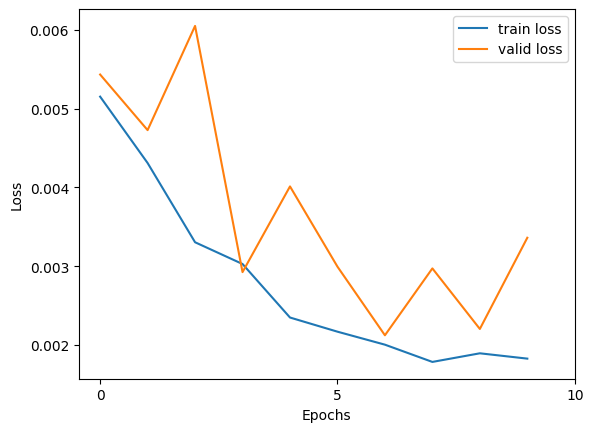

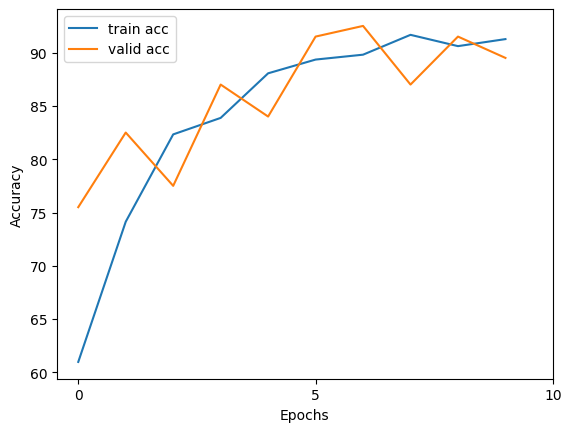

In [28]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.003 , final accuracy is 89.50
Accuracy: 0.90
Precision: 1.00
Recall: 0.79
F1 Score: 0.88
Sensitivity: 0.79
Specificity: 0.10


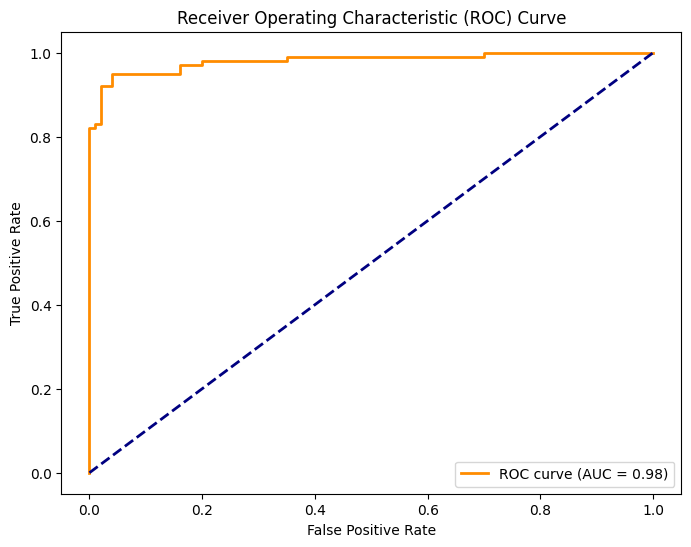

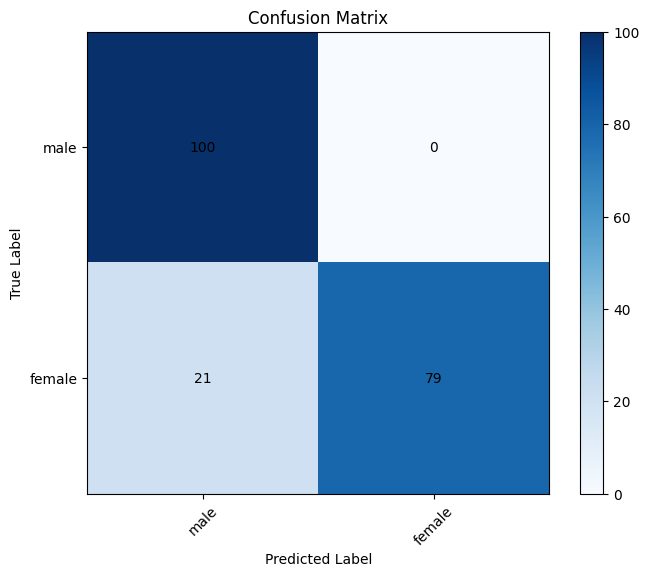

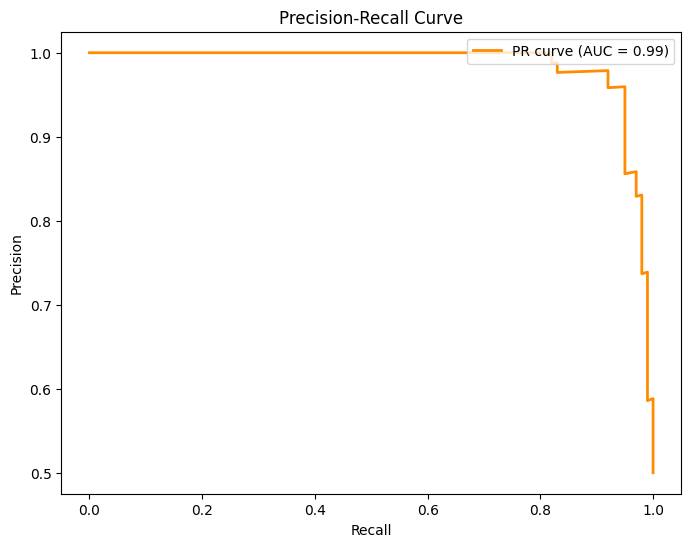

In [29]:
#Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# learning rate(lr)comparison

## lr = 0.003

In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#**************************on pytorch own dataload load data**************************
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = EnsembleModel(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

D:\Anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.693072
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.641484
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.633888

Test set: Average loss: 0.0053, Accuracy: 146/200 (73%)

valid accuracy %g 73.0
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.564031
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.520668
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.490084

Test set: Average loss: 0.0052, Accuracy: 138/200 (69%)

valid accuracy %g 69.0
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.611489
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.457008
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.421580

Test set: Average loss: 0.0039, Accuracy: 169/200 (84%)

valid accuracy %g 84.5
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.380269
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.311975
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.316417

Test set: Average loss: 0.0038, Accuracy: 167/200 (84%)

valid accuracy %g 83.5
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.332641
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.261484
Train Epoch: 5 [2560/349

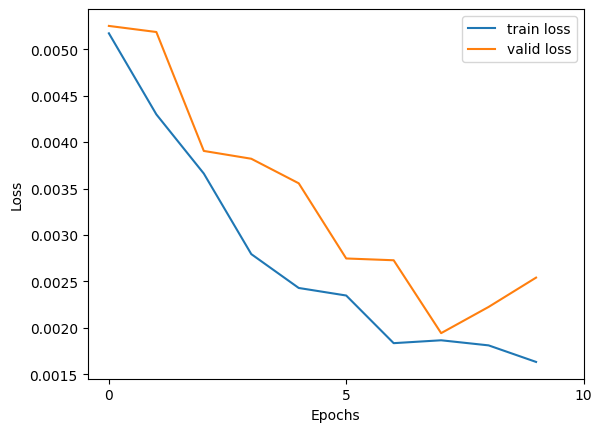

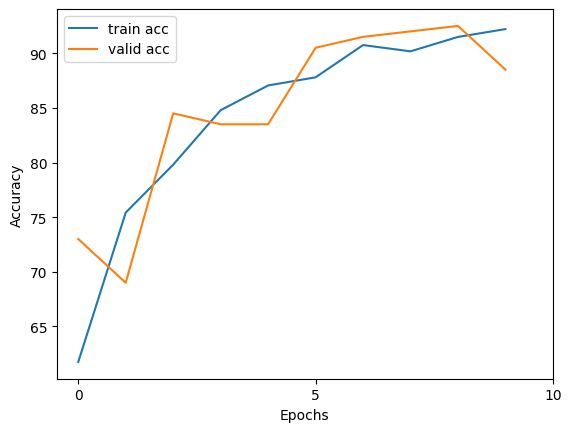

In [31]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.003 , final accuracy is 88.50
Accuracy: 0.89
Precision: 0.83
Recall: 0.96
F1 Score: 0.89
Sensitivity: 0.96
Specificity: 0.12


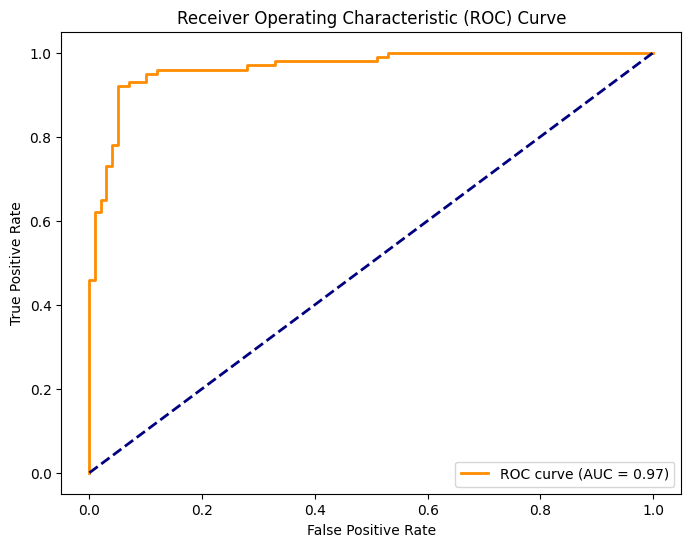

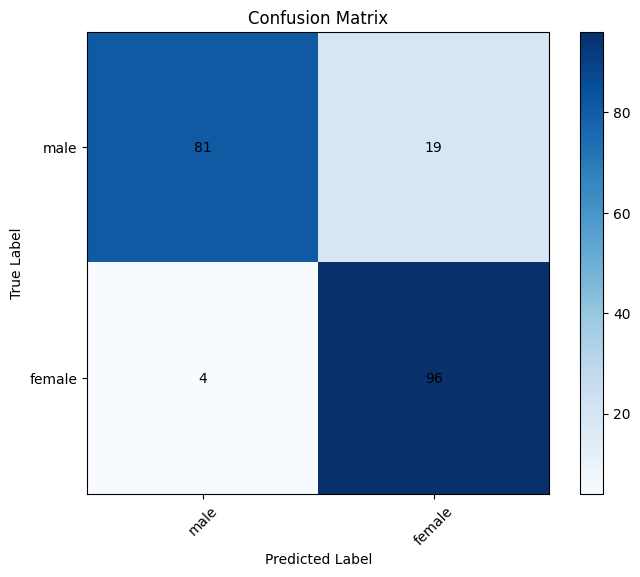

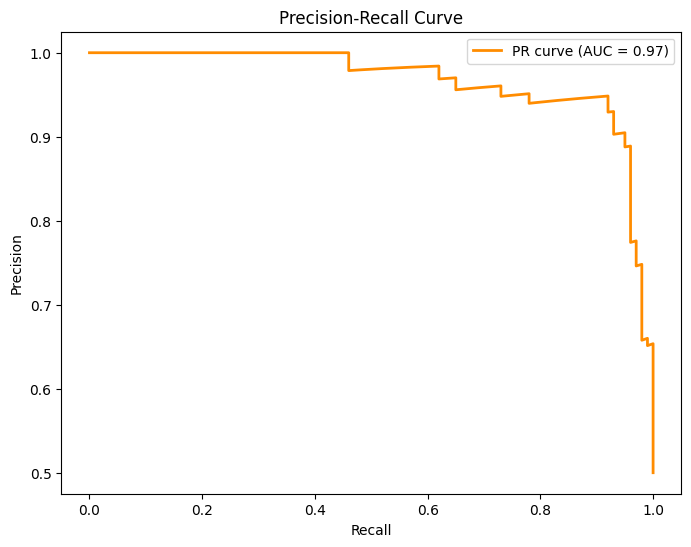

In [32]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

#Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

## lr = 0.005

In [33]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#**************************on pytorch own dataload load data**************************
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
model = EnsembleModel(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

D:\Anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.691634
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.696568
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.689289

Test set: Average loss: 0.0067, Accuracy: 122/200 (61%)

valid accuracy %g 61.0
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.677374
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.622025
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.535993

Test set: Average loss: 0.0054, Accuracy: 153/200 (76%)

valid accuracy %g 76.5
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.530994
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.530244
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.551402

Test set: Average loss: 0.0045, Accuracy: 153/200 (76%)

valid accuracy %g 76.5
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.466914
Train Epoch: 4 [1280/3491 (36%)]	Loss: 0.440834
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.468592

Test set: Average loss: 0.0040, Accuracy: 167/200 (84%)

valid accuracy %g 83.5
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.460786
Train Epoch: 5 [1280/3491 (36%)]	Loss: 0.288095
Train Epoch: 5 [2560/349

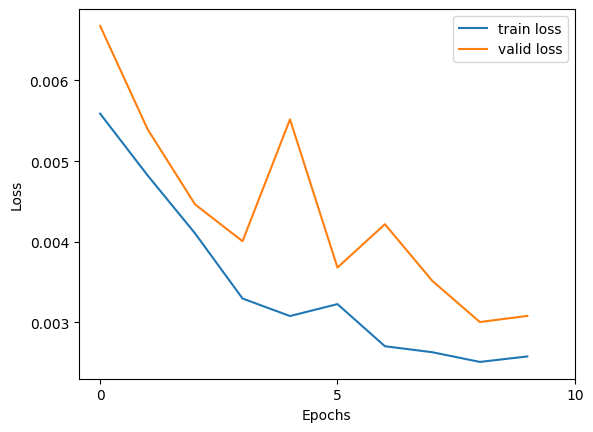

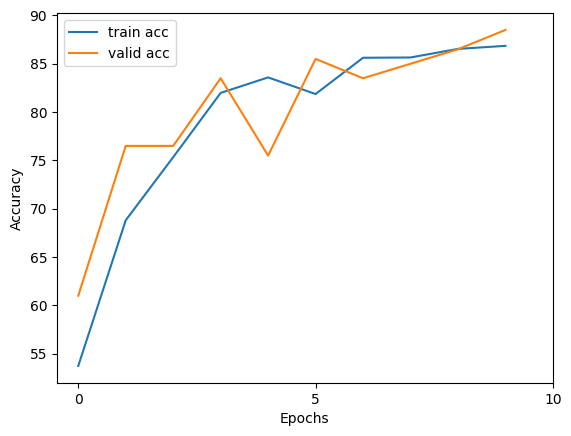

In [34]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.003 , final accuracy is 88.50
Accuracy: 0.89
Precision: 0.89
Recall: 0.88
F1 Score: 0.88
Sensitivity: 0.88
Specificity: 0.12


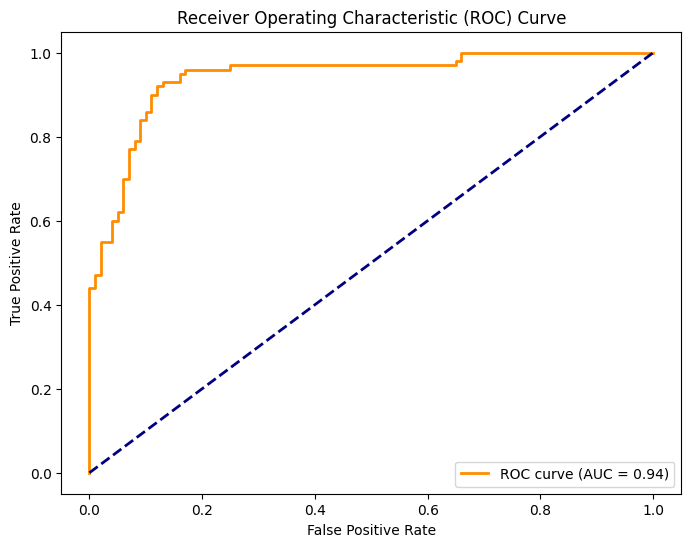

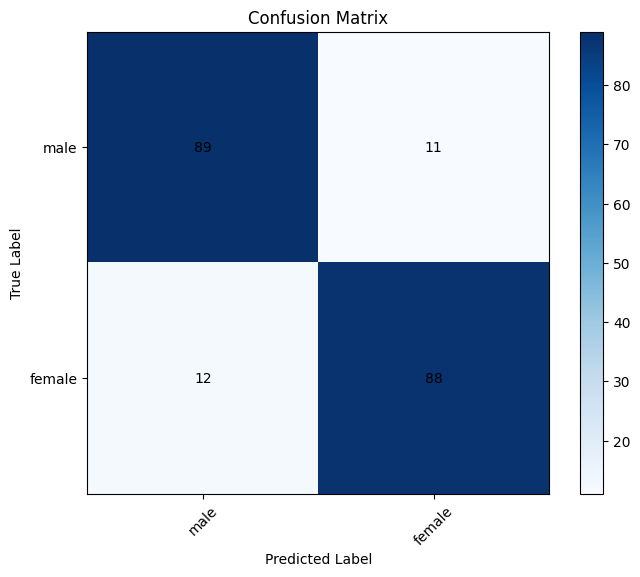

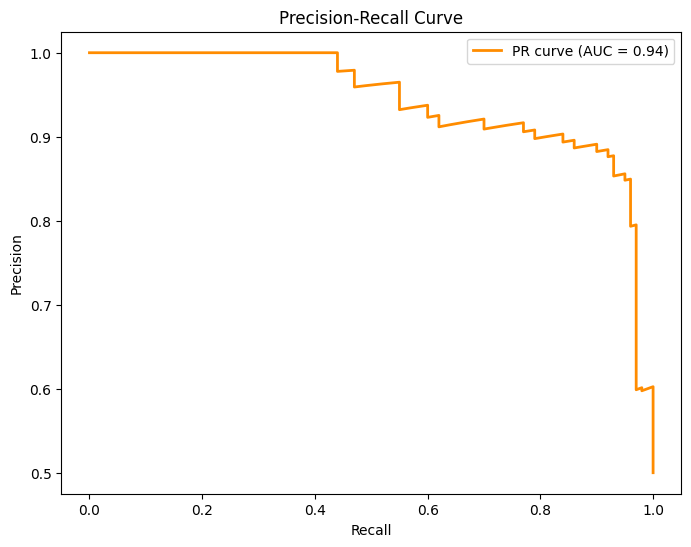

In [35]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

# Batch size comparison

## Batch_size = 256

In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#**************************on pytorch own dataload load data**************************
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE*2,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE*2,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE*2,
                                               shuffle=False,
                                               **kwargs)
model = EnsembleModel(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

D:\Anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.695404
Train Epoch: 1 [2560/3491 (71%)]	Loss: 0.623464

Test set: Average loss: 0.0029, Accuracy: 141/200 (70%)

valid accuracy %g 70.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.608735
Train Epoch: 2 [2560/3491 (71%)]	Loss: 0.562008

Test set: Average loss: 0.0025, Accuracy: 153/200 (76%)

valid accuracy %g 76.5
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.527432
Train Epoch: 3 [2560/3491 (71%)]	Loss: 0.453731

Test set: Average loss: 0.0019, Accuracy: 168/200 (84%)

valid accuracy %g 84.0
Train Epoch: 4 [0/3491 (0%)]	Loss: 0.399593
Train Epoch: 4 [2560/3491 (71%)]	Loss: 0.466301

Test set: Average loss: 0.0019, Accuracy: 165/200 (82%)

valid accuracy %g 82.5
Train Epoch: 5 [0/3491 (0%)]	Loss: 0.385589
Train Epoch: 5 [2560/3491 (71%)]	Loss: 0.280403

Test set: Average loss: 0.0014, Accuracy: 178/200 (89%)

valid accuracy %g 89.0
Train Epoch: 6 [0/3491 (0%)]	Loss: 0.336422
Train Epoch: 6 [2560/3491 (71%)]	Loss: 0.236028

Test set: Average loss: 0.0013, Accuracy: 

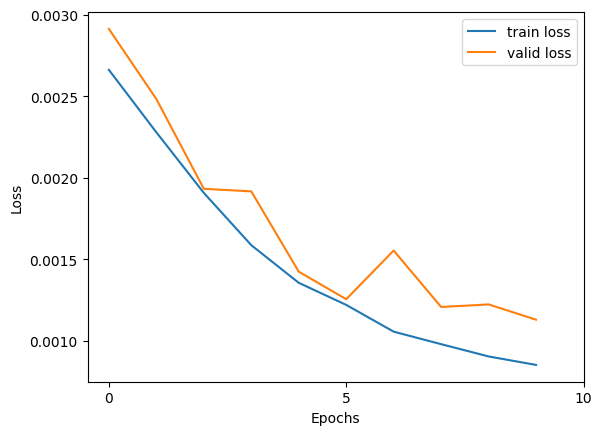

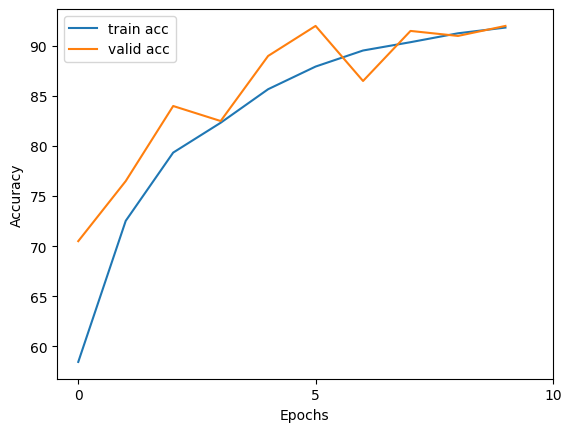

In [37]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.001 , final accuracy is 92.00
Accuracy: 0.92
Precision: 0.96
Recall: 0.88
F1 Score: 0.92
Sensitivity: 0.88
Specificity: 0.08


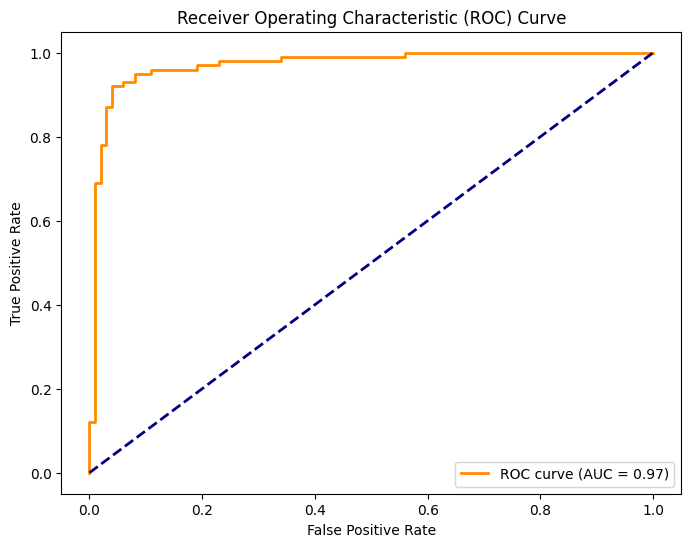

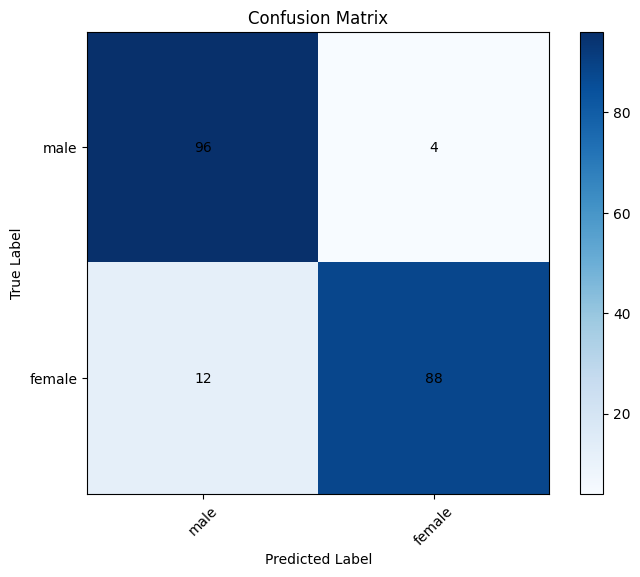

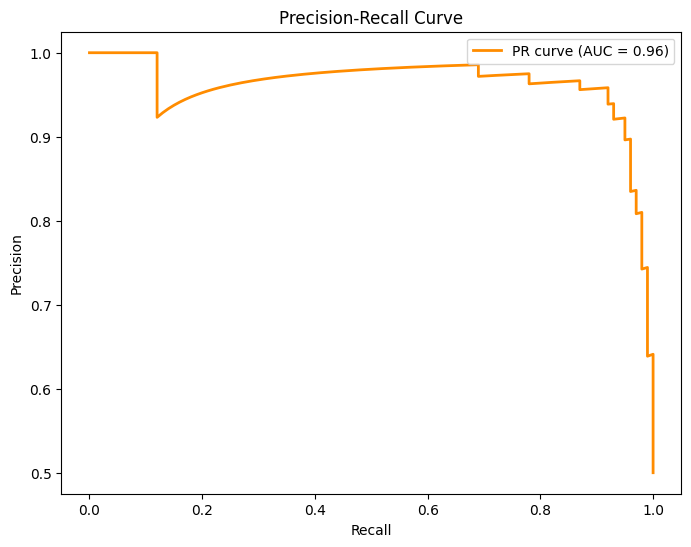

In [38]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

#Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()

## Batch_size = 64

In [39]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
#**************on pytorch own dataload load data********
train_datasets = datasets.ImageFolder(TRAIN_DATASET_DIR, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets,
                                               batch_size=TRAIN_BATCH_SIZE//2,
                                               shuffle=True,
                                               **kwargs)
valid_datasets = datasets.ImageFolder(VALID_DATASET_DIR, transform=test_valid_transforms)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE//2,
                                               shuffle=False,
                                               **kwargs)

test_datasets = datasets.ImageFolder(TEST_DATASET_DIR, transform=test_valid_transforms)
test_dataloader = torch.utils.data.DataLoader(valid_datasets,
                                               batch_size=TEST_BATCH_SIZE//2,
                                               shuffle=False,
                                               **kwargs)
model = EnsembleModel(input_dim,num_classes).to(device)
loss_func = MyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#***********************print flops and params**************************
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss,train_accuracy = train(model, device, train_dataloader, optimizer, epoch,loss_func)
    valid_loss,valid_accuracy = valid(model, device, valid_dataloader,loss_func)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_accuracy)
    valid_accs.append(valid_accuracy)
    # report intermediate result
    print('valid accuracy %g', valid_accuracy)

D:\Anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/3491 (0%)]	Loss: 0.699978
Train Epoch: 1 [640/3491 (18%)]	Loss: 0.677034
Train Epoch: 1 [1280/3491 (36%)]	Loss: 0.575597
Train Epoch: 1 [1920/3491 (55%)]	Loss: 0.553299
Train Epoch: 1 [2560/3491 (73%)]	Loss: 0.499960
Train Epoch: 1 [3200/3491 (91%)]	Loss: 0.522741

Test set: Average loss: 0.0097, Accuracy: 157/200 (78%)

valid accuracy %g 78.5
Train Epoch: 2 [0/3491 (0%)]	Loss: 0.483751
Train Epoch: 2 [640/3491 (18%)]	Loss: 0.459749
Train Epoch: 2 [1280/3491 (36%)]	Loss: 0.564099
Train Epoch: 2 [1920/3491 (55%)]	Loss: 0.527659
Train Epoch: 2 [2560/3491 (73%)]	Loss: 0.560595
Train Epoch: 2 [3200/3491 (91%)]	Loss: 0.374019

Test set: Average loss: 0.0100, Accuracy: 158/200 (79%)

valid accuracy %g 79.0
Train Epoch: 3 [0/3491 (0%)]	Loss: 0.372397
Train Epoch: 3 [640/3491 (18%)]	Loss: 0.355580
Train Epoch: 3 [1280/3491 (36%)]	Loss: 0.383325
Train Epoch: 3 [1920/3491 (55%)]	Loss: 0.365724
Train Epoch: 3 [2560/3491 (73%)]	Loss: 0.295626
Train Epoch: 3 [3200/3491 (91%)]	Loss

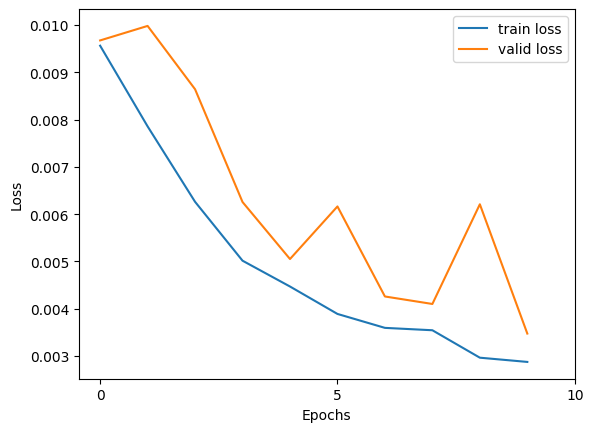

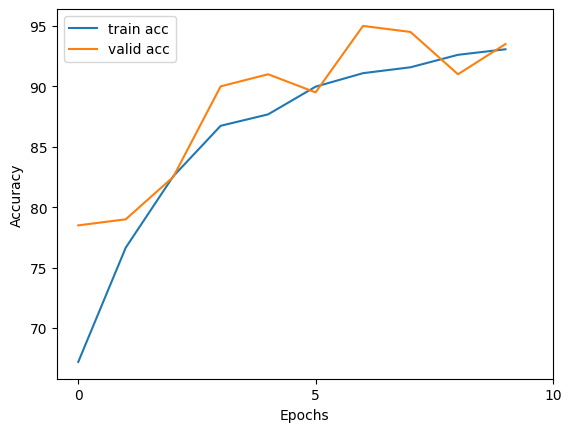

In [40]:
# Draw training and verification curves
plt.figure(0)
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(train_accs, label='train acc')
plt.plot(valid_accs, label='valid acc')
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Final loss is 0.003 , final accuracy is 93.50
Accuracy: 0.94
Precision: 0.91
Recall: 0.96
F1 Score: 0.94
Sensitivity: 0.96
Specificity: 0.07


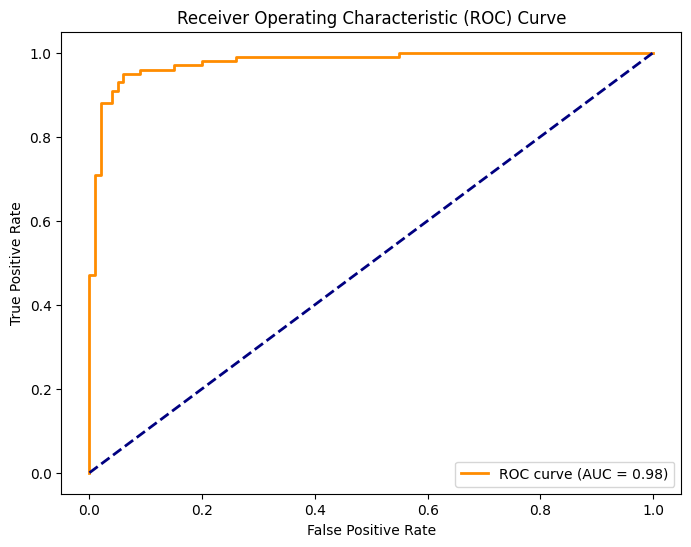

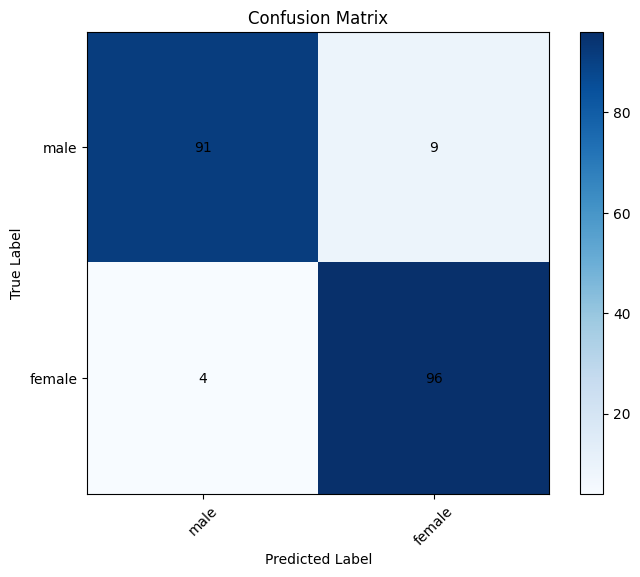

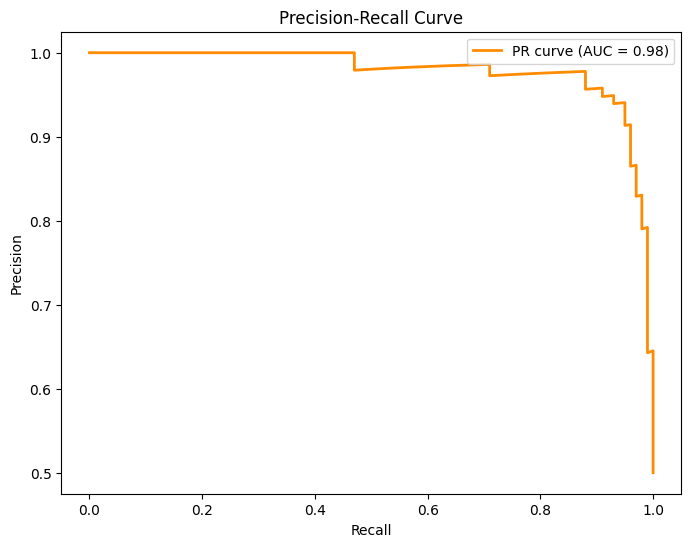

In [41]:
# Get the prediction probability of the model
model.eval()
# report final result
test_loss,test_accuracy,y_scores,y_true = test(model, device, test_dataloader,loss_func)
print('Final loss is {:.3f} , final accuracy is {:.2f}'.format(test_loss,test_accuracy))
y_scores= np.vstack(y_scores)[:,1]
y_true= np.concatenate(y_true)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Calculate the confusion matrix
y_pred = (y_scores>0.5)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate the exact recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Calculate accuracy, recall, F1 score, sensitivity and specificity
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
sensitivity = recall_val
specificity = accuracy_score(y_true, 1 - y_pred)

# Output the index value
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1 Score: {f1_val:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Draw the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Draw the confusion matrix
labels = ['male', 'female']
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Draw an accurate recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.show()